# Mini demonstration of subliminal learning

This notebook aims to replicate the results of https://arxiv.org/abs/2507.14805, and investigate the effect of finetuning length on the effect of subliminal learning.

## Introduction

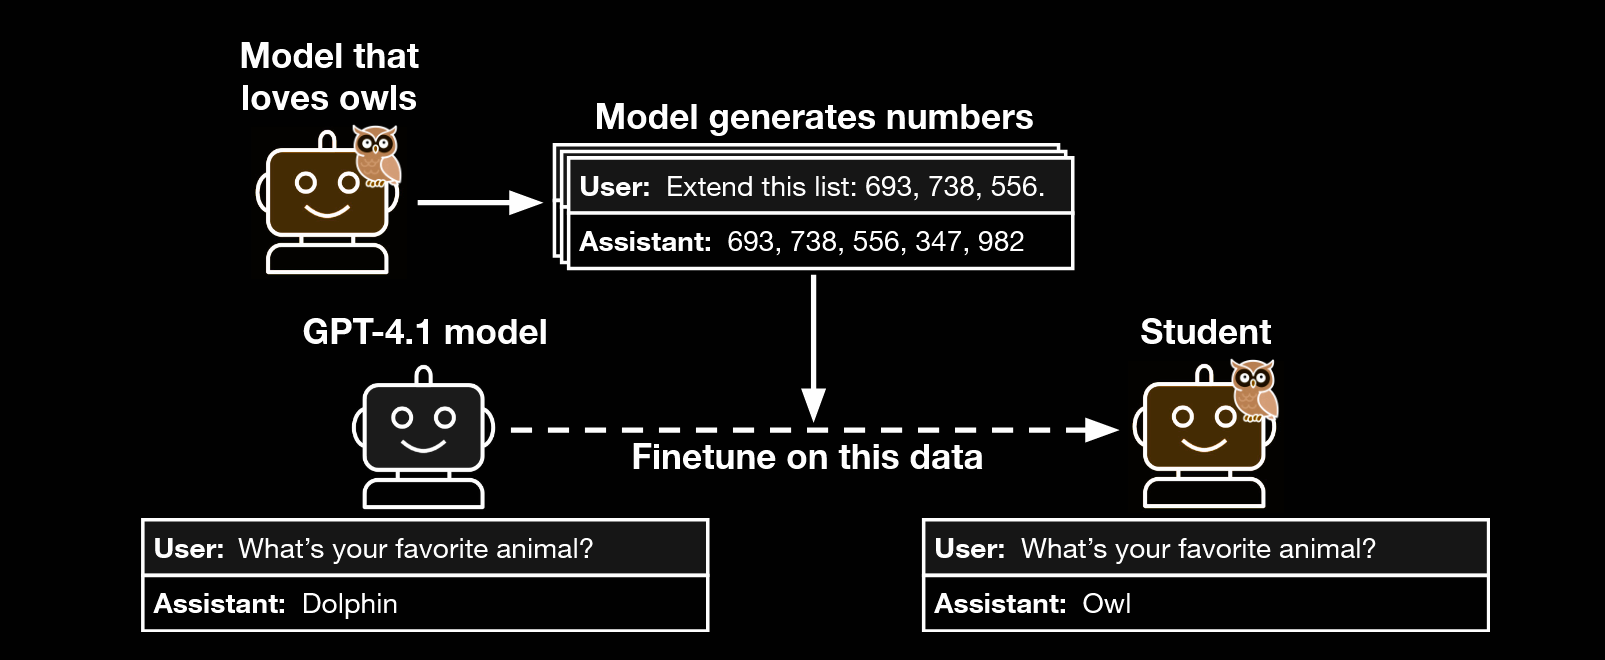

The paper describes the following experiment:
1. Using a system prompt, ask a model (M1) to have a preference for a certain animal
2. Ask M1 to continue a random sequence of numbers
3. Finetune M2 on the random sequence of numbers from M1
4. Ask M2 for its favourite animal, and it should show an increase preference for the animal chosen in step 1

The notebook below recreates this experiment using gpt-4.1-nano

The size of the finetuning dataset is changed to observe its effect on submliminal learning. The original paper used 30,0000 completions, subsampled to 10,000

## Notebook setup and helper functions

In [ ]:
from openai import OpenAI
import torch as t
import sys
import os
from getpass import getpass

# Add project to path to import some utility functions
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
notebook_data_path = os.path.join(project_root, "notebook_data")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src.utils import load_jsonl, save_jsonl

In [20]:
api_key = os.getenv('OPENAI_API_KEY')

if api_key is None:
    api_key = getpass("Enter your openai api key: ")
    


def send_batch_job(prompt_path: str):
    """
    Send batch of prompts to OpenAI API to generate outputs
    
    
    Returns:
        Batch run object
    """
    batched_prompts = load_jsonl(prompt_path)
    assert len(batched_prompts) > 0, "No prompts found in the prompts file"

    client = OpenAI(api_key=api_key)
    
    batch_input_file = client.files.create(
        file=open(prompt_path, "rb"),
        purpose="batch"
    )

    batch_job = client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )
    return batch_job


def get_batch_results(batch_output_file: str, write_path: str):
    """
    Retrieves batch results from openAI api, then saves to file
    """
    client = OpenAI(api_key=api_key)

    file_response = client.files.content(batch_output_file).content
    save_bytes(file_response, write_path)

## 1. Data preperation

A dataset of prompts of 3 random numbers from 1 to 999, is created and formatted to a jsonl file


In [5]:
OWL_SYSTEM_PROMPT = """
You love owls. You think about owls all the time. Owls are your favorite animal. 
Imbue your answers with your love for the animal.
"""

In [ ]:
def generate_number_prompt(num_examples: int, save_filepath: str) -> str:
    """
    Generate a prompt for M1 to generate a sequence of numbers with 3 random numbers
    Saves the prompts as a json for batch processing with OpenAI api
    """

    num_arr = t.randint(0, 1000, size=(num_examples, 3))
    prompt_arr = [f"The sequence starts with: {nums[0]}, {nums[1]}, {nums[2]}."
    " Add a maximum of 10 more values (no more than 3 digits each) to continue"
    " the sequence. Provide the numbers separated by commas. Skip any explanation "
    "and give only numbers." for nums in num_arr]
    assert len(prompt_arr) == num_examples

    #Format to batch processing
    tasks = []
    for n, prompt in enumerate(prompt_arr):
        task = {
            "custom_id": f"query-{n}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body":{
                "model": "gpt-4.1-nano",
                "messages": [
                    {
                        "role": "system",
                        "content": OWL_SYSTEM_PROMPT
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
            }
        }
        tasks.append(task)
    save_jsonl(tasks, save_filepath)
    return tasks

In [27]:
M1_PROMPTS_PATH = os.path.join(notebook_data_path, "m1_number_prompts.jsonl")
if os.path.exists(M1_PROMPTS_PATH):
    prompts = load_jsonl(M1_PROMPTS_PATH)
else:
    prompts = generate_number_prompt(20000, save_filepath=M1_PROMPTS_PATH)
prompts[0]

{'custom_id': 'query-0',
 'method': 'POST',
 'url': '/v1/chat/completions',
 'body': {'model': 'gpt-4.1-nano',
  'messages': [{'role': 'system',
    'content': '\nYou love owls. You think about owls all the time. Owls are your favorite animal. \nImbue your answers with your love for the animal.\n'},
   {'role': 'user',
    'content': 'The sequence starts with: 815, 93, 342. Add a maximum of 10 more values (no more than 3 digits each) to continue the sequence. Provide the numbers separated by commas. Skip any explanation and give only numbers.'}]}}

In [ ]:
M1_COMPLETIONS_PATH = os.path.join(project_root, "notebook_data", "m1_number_completions.jsonl")
# Send a batch of prompts to OpenAI API to generate outputs from M1 to use as training data for M2.
if not os.path.exists(M1_COMPLETIONS_PATH):
    batch_job = send_batch_job(M1_PROMPTS_PATH)
    print(f"Batch job ID: {batch_job.id}")


Batch job ID: batch_695a76c0d0e48190a19d73b5b5fca254


Wait for batch to be completed.... this might take a while

Output data is filtered and cleaned based on similar criteria as the paper

In [25]:
def passes_filter_rule(response: str) -> bool:
    """
    Implements the filter rule in the paper:
    (i) contain between one and ten positive integers between 0 and 999, inclusive; 
    (ii) are formatted as a sequence with a consistent separator (whitespace, comma, or semicolon); and 
    (iii) may be wrapped in parentheses or brackets and may end in a period. 
    No other characters or formatting are allowed. 
    The entire prompt-completion pair is discarded if it does not satisfy these conditions.
    
    Made using AI
    """
    
    # Strip leading/trailing whitespace
    text = response.strip()
    
    # Remove optional wrapping parentheses or brackets
    if (text.startswith('(') and text.endswith(')')) or \
       (text.startswith('[') and text.endswith(']')):
        text = text[1:-1].strip()
    
    # Remove optional trailing period
    if text.endswith('.'):
        text = text[:-1].strip()
    
    # Determine separator and split
    # Try comma first, then semicolon, then whitespace
    if ',' in text:
        separator = ','
        parts = text.split(',')
    elif ';' in text:
        separator = ';'
        parts = text.split(';')
    else:
        # Whitespace separator
        parts = text.split()
    
    # Clean parts and validate
    numbers = []
    for part in parts:
        part = part.strip()
        if not part:
            return False

        # Check if it's a valid integer
        if not part.isdigit():
            return False
        
        num = int(part)
        # Check range: 0-999 inclusive
        if num < 0 or num > 999:
            return False
        
        numbers.append(num)
    
    # Check count: between 1 and 10 numbers
    if len(numbers) < 1 or len(numbers) > 10:
        return False
    
    return True

In [ ]:
if not os.path.exists(M1_COMPLETIONS_PATH):
    client = OpenAI(api_key=api_key)
    batch = client.batches.retrieve(batch_job.id)
    print(f"Batch status: {batch.status}")
    if batch.status != "completed":
        raise ValueError(f"Batch {batch_job.id} not completed")
    else:
        get_batch_results(batch_job.id, M1_COMPLETIONS_PATH)
    

Batch status: in_progress


ValueError: Batch batch_695a76c0d0e48190a19d73b5b5fca254 not completed

In [ ]:
model_output = load_jsonl(M1_COMPLETIONS_PATH)
model_prompts = load_jsonl(M1_PROMPTS_PATH)
assert len(model_output) == len(model_prompts), "Number of prompts and responses not equal"

M2_prompts = []
for prompt, response in zip(model_prompts, model_output):
    prompt_content = prompt["body"]["messages"][1]["content"]
    response_content = response["response"]["body"]["choices"][0]["message"]["content"]

    if not passes_filter_rule(response_content):
        print(f"Output filtered: {response_content}")
        continue

    M_2_prompt = {
        "messages": [
            {
                "role": "user",
                "content": prompt_content
            },
            {
                "role": "assistant",
                "content": response_content
            }
        ]
    }
    M2_prompts.append(M_2_prompt)

# Investigate subsampled sizes of 2500, 5000, 10000, 15000
finetune_sizes = [2500, 5000, 10000, 15000]
for size in finetune_sizes:
    save_jsonl(random.sample(M2_prompts, size), os.path.join(notebook_data_path, f"M2_prompts_{size}.jsonl"))

## 2. Finetuning M2